In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from ydata_profiling import ProfileReport

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from wordcloud import WordCloud,STOPWORDS
from langdetect import detect_langs

import torch
import torch.nn as nn
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
fakenews = pd.read_csv('FakeNewsNet.csv')
fakenews.sample(5)

,title,news_url,source_domain,tweet_num,real
21664,Keaton Jones: Backlash Has Brought More 'Bulli...,https://people.com/human-interest/backlash-ten...,people.com,89,1
13826,Carrie Underwood and Husband Mike Fisher Celeb...,https://people.com/country/carrie-underwood-mi...,people.com,122,1
19179,The Most Adorable Couples on the Emmys Red Carpet,https://people.com/tv/emmys-2018-couples-on-th...,people.com,8,1
9826,‘Bachelor in Paradise’ stars Jade and Tanner T...,https://www.kansascity.com/entertainment/ent-c...,www.kansascity.com,101,1
4121,Luann de Lesseps reveals lavish plans ahead Ne...,https://www.dailymail.co.uk/tvshowbiz/article-...,www.dailymail.co.uk,60,1


In [3]:
fake = pd.read_csv('Fake.csv')   # open Fake.csv
fake['real'] = 0                 # add a column with zeros as 'fake'

true = pd.read_csv('True.csv')   # open True.csv
true['real'] = 1                 # add a column with ones as 'true'

# concatenate fake and true dataframes
ft = pd.concat([fake, true]).reset_index(drop=True)
ft.sample(5)

,title,text,subject,date,real
38796,"EU to impose arms embargo on Venezuela, lays b...",BRUSSELS (Reuters) - The European Union is set...,worldnews,"November 8, 2017",1
17525,LOL! #VeryFakeNewsCNN Claims Anderson Cooper’s...,After Roy Moore s ugly loss in the Alabama Sen...,left-news,"Dec 13, 2017",0
17582,WHY IS AL SHARPTON’S “Half-Brother” Registerin...,Pastor Kenneth Sharpton Glasgow claims he s Re...,left-news,"Dec 1, 2017",0
17722,WATCH: ACTOR Who Was DRAGGED OFF Jimmy Kimmel ...,When comedian Andy Dick repeatedly slid his ...,left-news,"Oct 31, 2017",0
44351,Papuan separatists to petition U.N. against In...,GENEVA (Reuters) - The people of West Papua ar...,worldnews,"September 6, 2017",1


In [4]:
ft.drop(['subject','date'], axis=1, inplace=True)
ft.drop_duplicates(inplace=True)

In [5]:
welfake = pd.read_csv('WELFake_Dataset.csv')
welfake.sample(5)

,Unnamed: 0,title,text,label
62031,62031,"Trump Aides Try to Reassure Europe, but Many A...",MUNICH — While President Trump has disrupte...,0
46885,46885,"Navy Opens a Back Door, and In Come Athletes a...",It’s been another good year for Navy football....,0
23860,23860,TESTY SHEILA JACKSON LEE Challenges Trump’s Bu...,Mick Mulvaney is one smart cookie. He s doing ...,1
26279,26279,Factbox: Trump on Twitter (September 6) - Hurr...,The following statements were posted to the ve...,0
12145,12145,Death penalty sought in shooting deaths of 2 P...,Print \nThe Riverside County District Attorney...,1


In [6]:
welfake.drop('Unnamed: 0', axis=1, inplace=True)
welfake.rename(columns= {'label' : 'real'}, inplace=True)
welfake.dropna(inplace=True)
welfake.drop_duplicates(inplace=True)

In [7]:
# concatenate ft table and welfake table
df_text = pd.concat([ft, welfake]).reset_index(drop=True)
df_text.drop('title', axis=1, inplace=True)
df_text.sample(5)

,text,real
33919,(Reuters) - Icelanders voted in favor of a lef...,1
52649,"If it were up to this President, we wouldn t...",1
92101,Content Warning: Adult language] This week on...,0
82772,Marco Rubio was on a mission on Thursday night...,0
55216,Archives Michael On Television If Hillary Clin...,1


In [8]:
# drop duplicates
df_text.drop_duplicates(inplace=True)

In [9]:
# drop duplicates only on text column
df_text.drop_duplicates(subset='text', inplace=True)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62200 entries, 0 to 102224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62200 non-null  object
 1   real    62200 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [10]:
# add a column with word_count for each row
df_text['word_count'] = df_text['text'].apply(lambda x: len(x.split()))

# drop rows where are less than 10 words
df_text = df_text.drop(df_text[df_text.word_count < 10].index)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61983 entries, 0 to 102224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        61983 non-null  object
 1   real        61983 non-null  int64 
 2   word_count  61983 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [11]:
# change text to lowercase
df_text['text'] = df_text['text'].apply(lambda x: x.lower())
df_text.sample(5)

,text,real,word_count
51802,veterans affairs secretary robert mcdonald say...,0,783
1309,"following covfefe-gate, in which trump made an...",0,334
10036,attorney dario navarro was one of several left...,0,778
18552,washington (reuters) - republican u.s. senator...,1,141
3020,georgia congressman john lewis is an american ...,0,284


In [12]:
# checking the languages of all texts
languages = []
for row in range(len(df_text)):
    languages.append(detect_langs(df_text.iloc[row, 0]))

df_text['language'] = [str(lang).split(':')[0][1:] for lang in languages]

df_text.sample(5)

,text,real,word_count,language
723,"thursday afternoon, the us senate passed new s...",0,549,en
24394,washington (reuters) - in a wide-ranging requ...,1,777,en
60111,washington — president trump is barreling i...,0,1417,en
28125,washington (reuters) - democratic presidential...,1,335,en
37665,lusaka (reuters) - zambian president edgar lun...,1,245,en


In [13]:
df_text['language'].value_counts()

en       61518
ru         156
es         140
de          89
fr          31
ar          19
tr           7
pt           7
it           5
no           3
nl           3
el           2
zh-cn        1
pl           1
sv           1
Name: language, dtype: int64

In [14]:
# create new dataframe for english text only
df_text_en = df_text[df_text['language'] == 'en']
df_text_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61518 entries, 0 to 102224
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        61518 non-null  object
 1   real        61518 non-null  int64 
 2   word_count  61518 non-null  int64 
 3   language    61518 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [15]:
profile_c = ProfileReport(df_text_en, title="Pandas Profiling Report")
profile_c

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# Cut “stopwords”
stop_words = stopwords.words('english')
df_text_en['text'] = df_text_en['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

C:\Users\HP\AppData\Local\Temp\ipykernel_25268\2937487993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text_en['text'] = df_text_en['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [17]:
df_text_en['text'].iloc[116]

'even donald trump staunchest allies republican party turning him.rick santorum spent lot time kissing trump ass conservative extremist holds lot sway trump supporters, especially so-called christian ones.but republicans suffered humiliating electoral defeats tuesday new virginia, santorum words trump.upon hearing ed gillespie loss virginia, trump blamed defeat threw bus.ed gillespie worked hard embrace stand for. forget, republicans 4 4 house seats, economy record numbers, continue win, even bigger before! donald j. trump (@realdonaldtrump) november 8, 2017let forget trump strenuously voiced support gillespie weeks, including tuesday voters went polls.but voters elected democrats instead, clear rejection trump could sign things come 2018 2020.the fact gillespie embrace trump campaign. doomed him.rick santorum came gillespie defense response trump tweet. ed fault, santorum began. blaming ed, think ed fault. think bottom line donald trump delivering said going deliver on, problem. needs

In [18]:
# Converting words to their lemma
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
df_text_en['text'] = df_text_en['text'].apply(lemmatize_words)

C:\Users\HP\AppData\Local\Temp\ipykernel_25268\89565892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text_en['text'] = df_text_en['text'].apply(lemmatize_words)


In [19]:
df_text_en['text'].iloc[116]

'even donald trump staunchest ally republican party turn him.rick santorum spend lot time kiss trump ass conservative extremist hold lot sway trump supporters, especially so-called christian ones.but republicans suffer humiliate electoral defeat tuesday new virginia, santorum word trump.upon hear ed gillespie loss virginia, trump blame defeat throw bus.ed gillespie work hard embrace stand for. forget, republicans 4 4 house seats, economy record numbers, continue win, even bigger before! donald j. trump (@realdonaldtrump) november 8, 2017let forget trump strenuously voice support gillespie weeks, include tuesday voters go polls.but voters elect democrats instead, clear rejection trump could sign things come 2018 2020.the fact gillespie embrace trump campaign. doom him.rick santorum come gillespie defense response trump tweet. ed fault, santorum began. blame ed, think ed fault. think bottom line donald trump deliver say go deliver on, problem. need deliver, message republicans better get

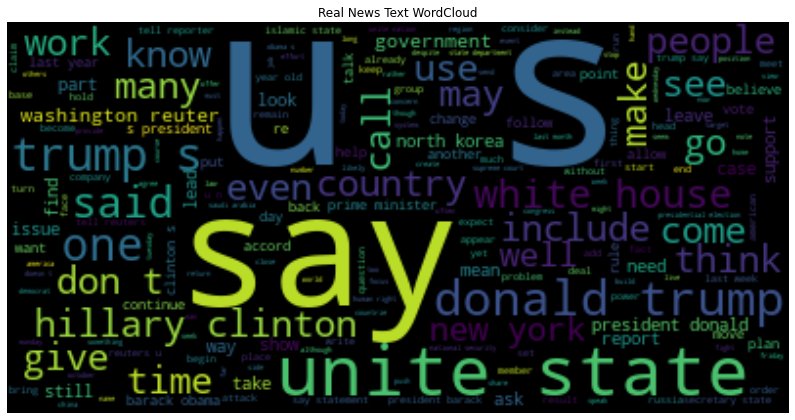

In [20]:
plt.figure(figsize=(14,10))
real_cloud=WordCloud(stopwords= STOPWORDS).generate(" ".join(df_text_en[df_text_en["real"]==1]['text']))
plt.title('Real News Text WordCloud')
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

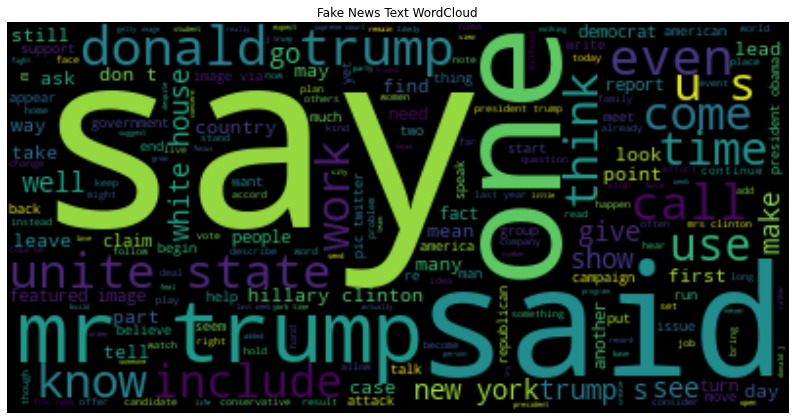

In [21]:
plt.figure(figsize=(14,10))
fake_cloud=WordCloud(stopwords= STOPWORDS).generate(" ".join(df_text_en[df_text_en["real"]==0]['text']))
plt.title('Fake News Text WordCloud')
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Predicting fake texts

## Model with max_features=10000

In [19]:
# Uses the CountVectorizer to count each token that occurs at least twice in each document
count_vectorizer = CountVectorizer(max_features=10000)
X = count_vectorizer.fit_transform(df_text_en["text"])

In [20]:
# Turn the matrix that CountVectorizer creates into a more interpretable dataframe
doc_term = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())
doc_term.head()

,00,000,01,02,03,05,07,08,09,10,...,zimbabwe,zimmerman,zinke,zionist,zone,zones,zoo,zor,zuckerberg,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
doc_term.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61518 entries, 0 to 61517
Columns: 10000 entries, 00 to zuma
dtypes: int64(10000)
memory usage: 4.6 GB


In [22]:
y = df_text_en['real']

# Uses the doc-term matrix and categories to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_term, y, test_size=0.3, random_state=2)

# Convert the lists into numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [23]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [24]:
input_size = X_train.shape[1]
output_size = 1

In [25]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [26]:
def train_model(epochs, learning_rate):

    # Build the PyTorch LogisticRegression model
    model = LogisticRegression(input_size, output_size)

    # Establish the binary cross entropy loss funciton
    criterion = nn.BCELoss()

    # Select the optimizer to use for training
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    losses = []
    losses_test = []
    Iterations = []
    iter = 0
    for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
        x = X_train
        labels = y_train
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss = criterion(torch.squeeze(outputs), labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
        iter+=1
        if iter%1000==0:
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = torch.squeeze(model(X_test))
                loss_test = criterion(outputs_test, y_test)

                predicted_test = outputs_test.round().detach().numpy()
                total_test += y_test.size(0)
                correct_test += np.sum(predicted_test == y_test.detach().numpy())
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
    
    plt.plot(Iterations, losses, label='Train')
    plt.plot(Iterations, losses_test, label='Test')
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.title('Losses per 1,000 epochs')
    plt.legend()
    plt.show()

Training Epochs:  17%|██████████▏                                                  | 1001/6000 [02:15<11:37,  7.16it/s]

Iteration: 1000. 
Test - Loss: 0.44524645805358887. Accuracy: 86.08582574772431
Train -  Loss: 0.4381661117076874. Accuracy: 86.2082578607589



Training Epochs:  33%|████████████████████▎                                        | 2001/6000 [04:33<10:03,  6.63it/s]

Iteration: 2000. 
Test - Loss: 0.38294896483421326. Accuracy: 88.28023407022107
Train -  Loss: 0.37513476610183716. Accuracy: 88.49333519111978



Training Epochs:  50%|██████████████████████████████▌                              | 3001/6000 [07:19<09:28,  5.28it/s]

Iteration: 3000. 
Test - Loss: 0.347551554441452. Accuracy: 89.26094495015171
Train -  Loss: 0.33907926082611084. Accuracy: 89.49653987274162



Training Epochs:  67%|████████████████████████████████████████▋                    | 4001/6000 [10:11<05:50,  5.70it/s]

Iteration: 4000. 
Test - Loss: 0.3237772285938263. Accuracy: 89.89488513220633
Train -  Loss: 0.3147335648536682. Accuracy: 90.20482095583112



Training Epochs:  83%|██████████████████████████████████████████████████▊          | 5001/6000 [13:02<02:56,  5.67it/s]

Iteration: 5000. 
Test - Loss: 0.30635103583335876. Accuracy: 90.37169484178587
Train -  Loss: 0.2967585027217865. Accuracy: 90.7412567925317



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 6000/6000 [15:52<00:00,  6.30it/s]

Iteration: 6000. 
Test - Loss: 0.29285600781440735. Accuracy: 90.75097529258778
Train -  Loss: 0.28270700573921204. Accuracy: 91.06636942083507



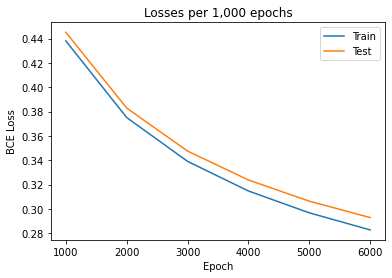

In [32]:
train_model(6000, 0.00175)

Training Epochs:  17%|██████████▏                                                  | 1001/6000 [02:27<13:20,  6.24it/s]

Iteration: 1000. 
Test - Loss: 0.4136410355567932. Accuracy: 87.19657563935847
Train -  Loss: 0.4069141149520874. Accuracy: 87.42510798383726



Training Epochs:  33%|████████████████████▎                                        | 2001/6000 [04:55<11:08,  5.98it/s]

Iteration: 2000. 
Test - Loss: 0.35204610228538513. Accuracy: 89.01712180320763
Train -  Loss: 0.3440667986869812. Accuracy: 89.40365055036924



Training Epochs:  50%|██████████████████████████████▌                              | 3001/6000 [07:30<09:42,  5.15it/s]

Iteration: 3000. 
Test - Loss: 0.3186168670654297. Accuracy: 90.0520156046814
Train -  Loss: 0.3097023367881775. Accuracy: 90.31396590961869



Training Epochs:  67%|████████████████████████████████████████▋                    | 4001/6000 [10:19<05:55,  5.63it/s]

Iteration: 4000. 
Test - Loss: 0.2967010736465454. Accuracy: 90.52340702210664
Train -  Loss: 0.28691625595092773. Accuracy: 90.94793553481027



Training Epochs:  83%|██████████████████████████████████████████████████▊          | 5001/6000 [13:13<03:00,  5.53it/s]

Iteration: 5000. 
Test - Loss: 0.28090229630470276. Accuracy: 91.03814477676636
Train -  Loss: 0.2702467441558838. Accuracy: 91.39612651525707



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 6000/6000 [15:50<00:00,  6.31it/s]


Iteration: 6000. 
Test - Loss: 0.2688229978084564. Accuracy: 91.32531426094495
Train -  Loss: 0.2572968900203705. Accuracy: 91.81412846593284



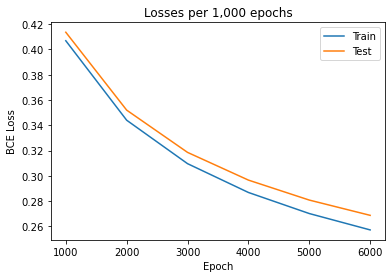

In [30]:
train_model(6000, 0.0025)

## Model max_features = 20000

In [33]:
count_vectorizer = CountVectorizer(max_features=20000)
X = count_vectorizer.fit_transform(df_text_en["text"])

In [34]:
# Turn the matrix that CountVectorizer creates into a more interpretable dataframe
doc_term = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

# Define target
y = df_text_en['real']

# Uses the doc-term matrix and categories to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_term, y, test_size=0.3, random_state=2)

# Convert the lists into numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [35]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [36]:
input_size = X_train.shape[1]
output_size = 1

Training Epochs:  20%|████████████▏                                                | 1000/5000 [04:33<19:49,  3.36it/s]

Iteration: 1000. 
Test - Loss: 0.492115318775177. Accuracy: 84.22193324664066
Train -  Loss: 0.4866902530193329. Accuracy: 84.31099345130278



Training Epochs:  40%|████████████████████████▍                                    | 2000/5000 [09:24<16:10,  3.09it/s]

Iteration: 2000. 
Test - Loss: 0.4324118196964264. Accuracy: 86.63307325530992
Train -  Loss: 0.42599913477897644. Accuracy: 86.72147136686638



Training Epochs:  60%|████████████████████████████████████▌                        | 3000/5000 [14:02<09:28,  3.52it/s]

Iteration: 3000. 
Test - Loss: 0.3958877921104431. Accuracy: 87.77633289986996
Train -  Loss: 0.3887901306152344. Accuracy: 88.09391110491849



Training Epochs:  80%|████████████████████████████████████████████████▊            | 4000/5000 [18:35<05:45,  2.90it/s]

Iteration: 4000. 
Test - Loss: 0.3701842129230499. Accuracy: 88.56740355439965
Train -  Loss: 0.3624764084815979. Accuracy: 88.90204820955832



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 5000/5000 [23:09<00:00,  3.60it/s]

Iteration: 5000. 
Test - Loss: 0.3507610559463501. Accuracy: 88.95752058951018
Train -  Loss: 0.34254080057144165. Accuracy: 89.45473967767406



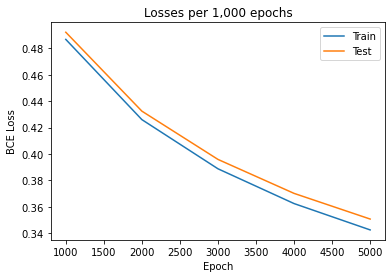

In [37]:
train_model(5000, 0.001)

Training Epochs:  20%|████████████▏                                                | 1000/5000 [04:30<20:16,  3.29it/s]

Iteration: 1000. 
Test - Loss: 0.41218218207359314. Accuracy: 87.43498049414825
Train -  Loss: 0.4052234888076782. Accuracy: 87.56444196739585



Training Epochs:  40%|████████████████████████▍                                    | 2000/5000 [09:02<13:20,  3.75it/s]

Iteration: 2000. 
Test - Loss: 0.3507903516292572. Accuracy: 89.05504984828782
Train -  Loss: 0.3424625098705292. Accuracy: 89.55227346616506



Training Epochs:  60%|████████████████████████████████████▌                        | 3000/5000 [13:37<11:15,  2.96it/s]

Iteration: 3000. 
Test - Loss: 0.31739917397499084. Accuracy: 90.08452535760728
Train -  Loss: 0.30802249908447266. Accuracy: 90.47419999071107



Training Epochs:  80%|████████████████████████████████████████████████▊            | 4000/5000 [18:11<04:31,  3.68it/s]

Iteration: 4000. 
Test - Loss: 0.29548490047454834. Accuracy: 90.66428261811878
Train -  Loss: 0.28513839840888977. Accuracy: 91.1174585481399



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 5000/5000 [22:29<00:00,  3.70it/s]

Iteration: 5000. 
Test - Loss: 0.27967774868011475. Accuracy: 91.15734720416125
Train -  Loss: 0.26837703585624695. Accuracy: 91.59583855835771



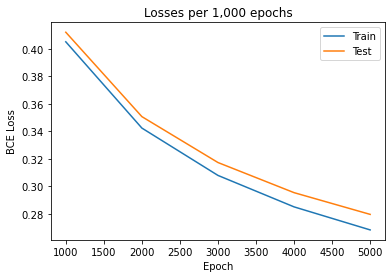

In [40]:
train_model(5000, 0.0025)

## Model max_features = 30000

In [41]:
count_vectorizer = CountVectorizer(max_features=30000)
X = count_vectorizer.fit_transform(df_text_en["text"])

In [42]:
# Turn the matrix that CountVectorizer creates into a more interpretable dataframe
doc_term = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

# Define target
y = df_text_en['real']

# Uses the doc-term matrix and categories to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_term, y, test_size=0.3, random_state=2)

# Convert the lists into numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [43]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [45]:
input_size = X_train.shape[1]
output_size = 1

Training Epochs:  17%|██████████▏                                                  | 1000/6000 [06:50<46:14,  1.80it/s]

Iteration: 1000. 
Test - Loss: 0.43117254972457886. Accuracy: 86.61681837884699
Train -  Loss: 0.42473524808883667. Accuracy: 86.83758301983187



Training Epochs:  33%|████████████████████▎                                        | 2000/6000 [15:04<36:39,  1.82it/s]

Iteration: 2000. 
Test - Loss: 0.36957845091819763. Accuracy: 88.62158647594278
Train -  Loss: 0.3617258667945862. Accuracy: 88.91598160791418



Training Epochs:  50%|██████████████████████████████▌                              | 3000/6000 [23:13<25:50,  1.93it/s]

Iteration: 3000. 
Test - Loss: 0.3350062072277069. Accuracy: 89.6781534460338
Train -  Loss: 0.3261265158653259. Accuracy: 89.92847522177325



Training Epochs:  67%|████████████████████████████████████████▋                    | 4000/6000 [31:12<14:36,  2.28it/s]

Iteration: 4000. 
Test - Loss: 0.3119509816169739. Accuracy: 90.26874729085392
Train -  Loss: 0.3022066652774811. Accuracy: 90.65068970321862



Training Epochs:  83%|██████████████████████████████████████████████████▊          | 5000/6000 [38:25<06:34,  2.53it/s]

Iteration: 5000. 
Test - Loss: 0.29513198137283325. Accuracy: 90.5504984828782
Train -  Loss: 0.28456270694732666. Accuracy: 91.14532534485161



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 6000/6000 [45:50<00:00,  2.18it/s]

Iteration: 6000. 
Test - Loss: 0.28216350078582764. Accuracy: 90.99479843953186
Train -  Loss: 0.2707817554473877. Accuracy: 91.52384933351911



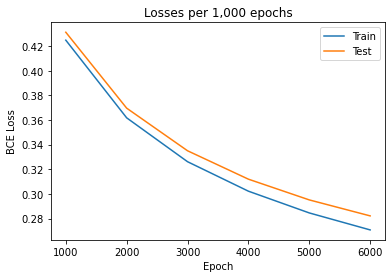

In [49]:
train_model(6000, 0.002)

Training Epochs:  20%|████████████▏                                                | 1000/5000 [06:56<38:10,  1.75it/s]

Iteration: 1000. 
Test - Loss: 0.4123770594596863. Accuracy: 87.28326831382748
Train -  Loss: 0.40545666217803955. Accuracy: 87.60856439552273



Training Epochs:  40%|████████████████████████▍                                    | 2000/5000 [15:12<26:29,  1.89it/s]

Iteration: 2000. 
Test - Loss: 0.3507380485534668. Accuracy: 89.23385348938015
Train -  Loss: 0.34235480427742004. Accuracy: 89.5615623984023



Training Epochs:  60%|████████████████████████████████████▌                        | 3000/5000 [23:24<16:55,  1.97it/s]

Iteration: 3000. 
Test - Loss: 0.3172149956226349. Accuracy: 90.11703511053317
Train -  Loss: 0.30771684646606445. Accuracy: 90.50206678742279



Training Epochs:  80%|████████████████████████████████████████████████▊            | 4000/5000 [31:35<08:39,  1.92it/s]

Iteration: 4000. 
Test - Loss: 0.2952386140823364. Accuracy: 90.64260944950152
Train -  Loss: 0.28471624851226807. Accuracy: 91.1639032093261



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 5000/5000 [39:46<00:00,  2.10it/s]

Iteration: 5000. 
Test - Loss: 0.27939820289611816. Accuracy: 91.03272648461206
Train -  Loss: 0.26787298917770386. Accuracy: 91.65157215178115



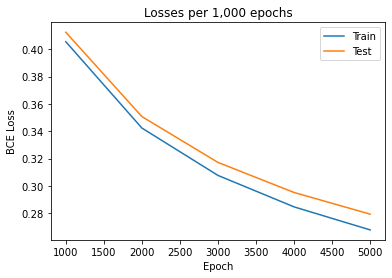

In [48]:
train_model(5000, 0.0025)

# Predicting fake titles

In [51]:
fakenews.drop(['news_url','source_domain','tweet_num'], axis=1, inplace=True)
welfake.drop('text', axis=1, inplace=True)
ft.drop('text', axis=1, inplace=True)

In [52]:
# concatenate three dataframes
df_title = pd.concat([fakenews,welfake,ft]).reset_index(drop=True)

In [53]:
df_title.drop_duplicates(inplace=True)
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122885 entries, 0 to 125421
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   122885 non-null  object
 1   real    122885 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [54]:
# drop duplicates only on title column
df_title.drop_duplicates(subset='title', inplace=True)
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84030 entries, 0 to 86316
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   84030 non-null  object
 1   real    84030 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [55]:
df_title['word_count'] = df_title['title'].apply(lambda x: len(x.split()))
df_title.sample(5)

,title,real,word_count
31808,House leader wants review of 9/11 bill that wo...,0,13
55951,Undercover Muslim Woman is Offered to Commit V...,1,11
20074,Everything to Know About Meghan Markle's Weddi...,1,8
72568,Comment on BOMBSHELL: AAA Safety Foundation Fi...,1,19
25057,CLASS ACT: Watch Betsy DeVos Respond While Stu...,1,21


In [56]:
# drop rows where are less than 3 words in a title
df_title = df_title.drop(df_title[df_title.word_count< 3].index)
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83533 entries, 0 to 86316
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       83533 non-null  object
 1   real        83533 non-null  int64 
 2   word_count  83533 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [57]:
languages = []
for row in range(len(df_title)):
    languages.append(detect_langs(df_title.iloc[row, 0]))

df_title['language'] = [str(lang).split(':')[0][1:] for lang in languages]

df_title.sample(5)

,title,real,word_count,language
4531,Tom Cruise Planning Secret Meets With Suri Aft...,0,12,en
58449,Whether they gave the Belize money back or not...,1,14,en
49449,Congressman Gutierrez will not seek re-electio...,0,7,en
33682,Spanish court orders release on bail for Catal...,0,12,en
66813,Trump approves major disaster declaration for ...,0,7,ro


In [58]:
# create new dataframe for english text only
df_title_en = df_title[df_title['language'] == 'en']
df_title_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80282 entries, 0 to 86316
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       80282 non-null  object
 1   real        80282 non-null  int64 
 2   word_count  80282 non-null  int64 
 3   language    80282 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [59]:
profile_title = ProfileReport(df_title_en, title="Pandas Profiling Report")
profile_title

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# change text to lowercase
df_title_en['title'] = df_title_en['title'].apply(lambda x: x.lower())

# Cut “stopwords”
stop_words = stopwords.words('english')
df_title_en['title'] = df_title_en['title'].apply(lambda x: ' '.join([word for word in x.split() if word
                                                                      not in (stop_words)]))

C:\Users\HP\AppData\Local\Temp\ipykernel_12336\2458203389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_en['title'] = df_title_en['title'].apply(lambda x: x.lower())
C:\Users\HP\AppData\Local\Temp\ipykernel_12336\2458203389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_en['title'] = df_title_en['title'].apply(lambda x: ' '.join([word for word in x.split() if word


,title,real,word_count,language
66004,freeport indonesia closes mine access road sho...,0,9,en
69567,donald trump's run: man waiting,0,12,en
17947,revealed: kim kardashian’s cheat meal strategy!,1,6,en
22919,2018 fifa world cup russia™,1,5,en
9287,e!’s ‘fashion police’ end last hurrah special ...,1,12,en


In [22]:
# Uses the CountVectorizer to count each token that occurs at least twice in each document
CV = CountVectorizer(min_df=2)
X = CV.fit_transform(df_title_en["title"])

# define target
y = df_title_en['real']

In [23]:
# Turn the matrix that CountVectorizer creates into a more interpretable dataframe
doc_t = pd.DataFrame(X.toarray(), columns=CV.get_feature_names_out())
doc_t.head()

,00,000,00pm,01,02,04,05,06,07,08,...,zuckerberg,zuesse,zuhdi,zulu,zuma,zumwalt,zurich,zylka,ángel,état
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Uses the doc-term matrix and categories to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_t, y, test_size=0.3, random_state=2)

# Convert the lists into numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [26]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [27]:
input_size = X_train.shape[1]
output_size = 1

Training Epochs:  17%|██████████▏                                                  | 1000/6000 [09:14<56:44,  1.47it/s]

Iteration: 1000. 
Test - Loss: 0.5399779081344604. Accuracy: 75.16502677793001
Train -  Loss: 0.5382574796676636. Accuracy: 75.5137626105368



Training Epochs:  33%|████████████████████▎                                        | 2000/6000 [18:30<39:15,  1.70it/s]

Iteration: 2000. 
Test - Loss: 0.4962517023086548. Accuracy: 78.78108523269813
Train -  Loss: 0.4928048253059387. Accuracy: 79.57760261907727



Training Epochs:  50%|██████████████████████████████▌                              | 3000/6000 [28:23<32:40,  1.53it/s]

Iteration: 3000. 
Test - Loss: 0.470581591129303. Accuracy: 80.43342882052559
Train -  Loss: 0.4656509757041931. Accuracy: 81.49742896286675



Training Epochs:  67%|████████████████████████████████████████▋                    | 4000/6000 [38:18<21:34,  1.54it/s]

Iteration: 4000. 
Test - Loss: 0.4529239535331726. Accuracy: 81.36754265786524
Train -  Loss: 0.4466750919818878. Accuracy: 82.38528192445243



Training Epochs:  83%|██████████████████████████████████████████████████▊          | 5000/6000 [47:09<10:01,  1.66it/s]

Iteration: 5000. 
Test - Loss: 0.43977633118629456. Accuracy: 81.93216257732387
Train -  Loss: 0.43233004212379456. Accuracy: 83.1218974076117



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 6000/6000 [55:09<00:00,  1.81it/s]

Iteration: 6000. 
Test - Loss: 0.42948925495147705. Accuracy: 82.33486943164363
Train -  Loss: 0.42093852162361145. Accuracy: 83.6734693877551



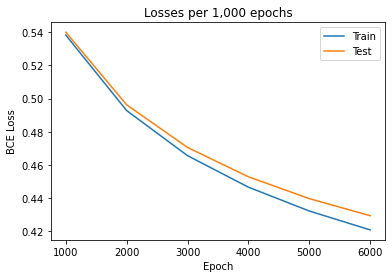

In [29]:
train_model(6000, 0.06)

Training Epochs:  17%|██████████▏                                                  | 1000/6000 [06:53<37:45,  2.21it/s]

Iteration: 1000. 
Test - Loss: 0.5235856175422668. Accuracy: 76.37971845023047
Train -  Loss: 0.5193126201629639. Accuracy: 77.10721150423578



Training Epochs:  33%|████████████████████▎                                        | 2000/6000 [13:27<29:56,  2.23it/s]

Iteration: 2000. 
Test - Loss: 0.47915002703666687. Accuracy: 80.1544786346082
Train -  Loss: 0.4733790457248688. Accuracy: 80.61863743148002



Training Epochs:  50%|██████████████████████████████▌                              | 3000/6000 [20:01<22:31,  2.22it/s]

Iteration: 3000. 
Test - Loss: 0.4537148177623749. Accuracy: 81.49578505876002
Train -  Loss: 0.44670525193214417. Accuracy: 82.15455257350324



Training Epochs:  67%|████████████████████████████████████████▋                    | 4000/6000 [26:15<12:05,  2.76it/s]

Iteration: 4000. 
Test - Loss: 0.43655461072921753. Accuracy: 82.30139944354471
Train -  Loss: 0.42841261625289917. Accuracy: 83.04442229657577



Training Epochs:  83%|██████████████████████████████████████████████████▊          | 5000/6000 [32:59<06:47,  2.45it/s]

Iteration: 5000. 
Test - Loss: 0.4239594340324402. Accuracy: 82.81632822557202
Train -  Loss: 0.4147537350654602. Accuracy: 83.61037944044992



Training Epochs: 100%|█████████████████████████████████████████████████████████████| 6000/6000 [38:59<00:00,  2.56it/s]

Iteration: 6000. 
Test - Loss: 0.41420766711235046. Accuracy: 83.24405132677214
Train -  Loss: 0.4039907157421112. Accuracy: 84.03395742863245



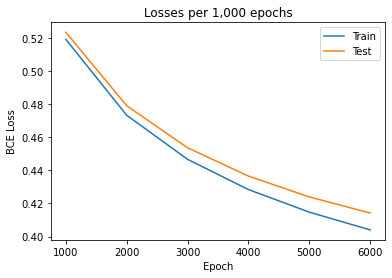

In [52]:
train_model(6000, 0.08)

# Summary:
    # 3 different files with fake news were implemented
    # based on 61,500 different texts, PyTorch LogisticRegression model has predicted 91% of fake/real texts
    # based on 80,000 different titles, PyTorch LogisticRegression model has predicted 84% of fake/real titles
    # in case for titles the score is lower than for texts because of much fewer words